# Data Mining Versuch Music Clustering
* Autor: Prof. Dr. Johannes Maucher
* Datum: 16.10.2015
* Update für Spotify API: Manuel Eberhardinger
* Datum: 23.04.2022

[Übersicht Versuche im Data Mining Praktikum](http://maucher.pages.mi.hdm-stuttgart.de/ai/page/dm/)

# Einführung
## Lernziele:
In diesem Versuch sollen Kenntnisse in folgenden Themen vermittelt werden:

* Kennenlernen der Spotify API
* Abfrage von Audio-Merkmalen über die Spotify API (Feature Extraction)
* Optimierung mit dem genetischen Algorithmus
* Selektion der aussagekräftigsten Merkmale (Feature Selection)
* Clustering von Musikfeatures (automatische Playlistgenerierung)


## Vor dem Versuch zu klärende Fragen

### Kennenlernen der Spotify API und Merkmalsextraktion
In diesem Versuch wird die [Spotify API](https://developer.spotify.com/documentation/web-api/) eingesetzt, um die Features der Audio Analyse  von dem [API Endpoint](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis) zu bekommen. Erstellen sie einen [Spotify Developer Account](https://developer.spotify.com/dashboard/) und einen API Key damit Sie die Audio Features von Spotify abfragen können. Machen Sie sich zunächst mit dem in Kapitel [Gegebene Module zur Spotify API und Feature Extraction](#Gegebene-Module-zur-Spotify-API-und-Feature-Extraction) aufgeführten Code vertraut. Versuchen Sie Funktion und Ablauf dieses Programms zu verstehen und beantworten Sie folgende Fragen.

1. Machen Sie sich mit der Spotify API vertraut und dem Python Package [Spotipy](https://spotipy.readthedocs.io/en/2.19.0/). Stellen Sie ein paar interessante Abfragen an die Spotify API über Künstler, Tracks oder ähnliches.
2. Machen Sie sich mit dem Endpoint für die [Audio Analyse](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis) vertraut. Was für Daten liefert der Endpoint zurück?
3. Was versteht man unter den statistischen Größen *Mittelwert, Standardabweichung, Skewness und Kurtosis*?
4. Insgesamt werden 112 Merkmale pro Musiksequenz extrahiert. Beschreiben Sie kurz diese Merkmale.


In [30]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
CLIENT_ID = "46b83c2cc04a4ca1925d74d992a440d2"
CLIENT_SECRET = "cd3b5aded1b049d38f5bdc8a2c3a8274"
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID,
                                                           client_secret=CLIENT_SECRET))

In [31]:
result = sp.search(q="artist:01099", type="artist", limit=1)

art_id = result['artists']['items'][0]['id']
top_tracks = sp.artist_top_tracks(art_id, country='DE')

print("Top 10 Lieder von 01099 in Deutschland:\n")
for track in top_tracks['tracks']:
        print(track['name'])

related_artists = sp.artist_related_artists(art_id)
print("\n------------------------------")
print("Ähnliche Artists zu 01099:\n")
for artist in related_artists['artists']:
    print(artist['name'])

print("\n------------------------------")
print("10 neu erschienene Alben in Deutschland:\n")
new_releases = sp.new_releases(country='DE', limit=10)
# display(new_releases)
for album in new_releases['albums']['items']:
    print(f"{album['name']} von {album['artists'][0]['name']}")


Top 10 Lieder von 01099 in Deutschland:

Glücklich
Frisch
Durstlöscher
VHS
Dies & Das
2000er
Schnelle Brille
Kreta 3.0
Dachfenster
Sportlich

------------------------------
Ähnliche Artists zu 01099:

badchieff
Big Pat
$OHO BANI
Longus Mongus
BHZ
makko
Rrotzer
MAJAN
viko63
Samo104
MotB
LUIS
NUGAT
OMG
Lugatti & 9ine
Beyazz
Symba
ART
Monk
Endzone

------------------------------
10 neu erschienene Alben in Deutschland:

Mr. Morale & The Big Steppers von Kendrick Lamar
Dance Fever von Florence + The Machine
So Far So Good von The Chainsmokers
MORE D4TA von Moderat
Dropout Boogie von The Black Keys
ESQUEMAS von Becky G
DREI von OK KID
Ravage von Mogli
I Blame The World von Sasha Alex Sloan
Come Home The Kids Miss You von Jack Harlow


### 2. Audio Analyse

Der Endpunkt liefert neben den Metadaten der Anfrage noch für die unterschiedlichen Einteilungen des Tracks sämtliche Audiomerkmale. Hierbei werden Audiomerkmale für den gesamten Track, für die einzelnen Takte, für die einzelne Taktschläge, für Sektionen und für Segmente des Tracks zurückgegeben. 
Für jedes Audiomerkmal wird zusätzlich noch eine Sicherheit mit angegeben, die angibt mit welcher Sicherheit der Wert für das Audiomerkmal stimmt.

### 3. Mittelwert, Standardabweichung, Skewness und Kurtosis

__Mittelwert__:

Der Mittelwert gibt den Durchschnittswert einer Menge an Werten an. Hierbei spielt die Reihenfolge der Werte keine Rolle aber der Mittelwert wird stark durch Ausreißer beeinflusst.

__Standardabweichung__:

Die Standardabweichung gibt an wie stark die Werte um den Mittelwert herum streuen. Ist die Standardabweichung kleine streuen die Werte kaum um den Mittelwert. Ist sie aber groß, streuen die Werte stark um den Mittelwert.

__Skewness__:
- Gibt an wie unsymmetrisch die Verteilung der Werte ist
    - Viele Werte kleiner als Mittelwert und wenige größer führt zu einer nach links geneignete Verteilung
    
[Bildquelle](https://upload.wikimedia.org/wikipedia/commons/c/cc/Relationship_between_mean_and_median_under_different_skewness.png)   
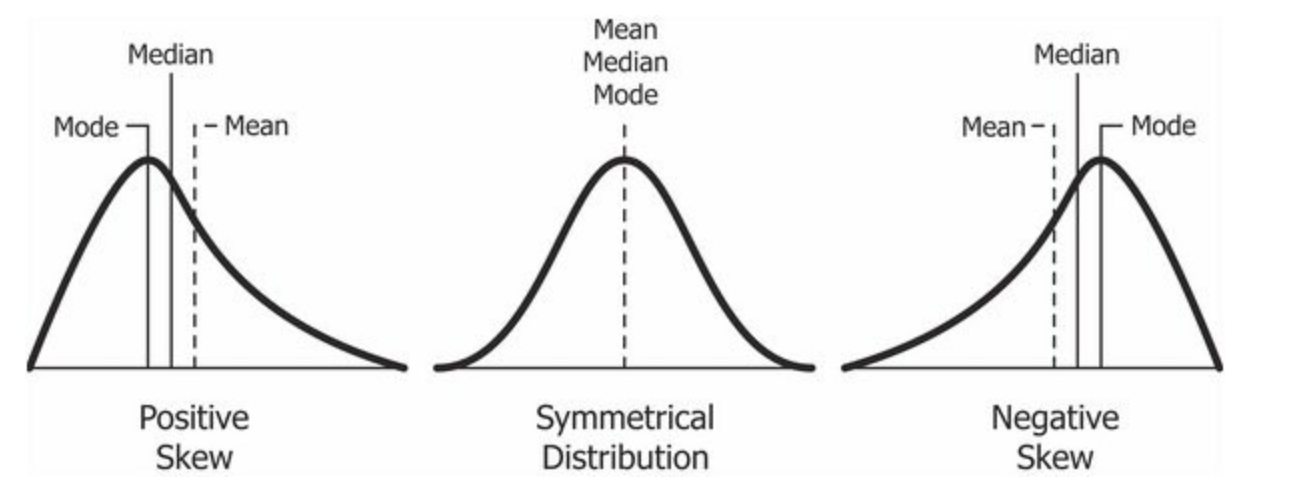

    
__Kurtosis__:
- Gibt an wie gestreckt/gestaucht die Verteilung der Werte ist
    - Viele Werte nahe um den Mittelwert und wenige weiter weg führt zu einer getreckten Verteilung

[Bildquelle](https://www.daytrading.com/kurtosis)
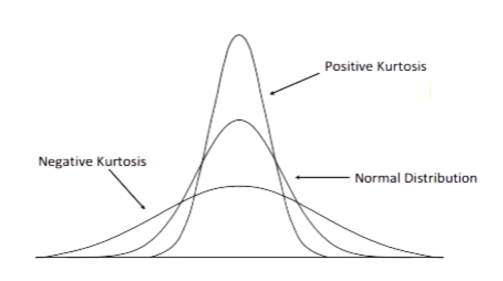
    
### 4. Merkmale Erläuterung

Mit einem Audio Segment wird ein kleiner Ausschnitt von dem Track beschrieben. Dies wird für die extrahierung der Features verwendet. 

Extrahierte Features:
- Loudness
    - Gibt an wie laut das Segment ist
- Pitches
    - Gibt die Tonlage des Segmentes an
- Timbre
    - Ist die 'Tonfarbe' des Segmentes. Hierüber können verschiedene Instrumente, Stimme etc. identifiziert werden.
- Duration
    - Gibt die Länge des Segmentes an

Mit den Zahlen 10, 20, 33 und 100 wird angegeben, wie fein die Segmente unterteilt werden sollen bzw. wieviele Segmente jeweils verwendet werden sollen für die Berechnung der Merkmale. Hierbei ist 10 die feinste und 100 die gröbste Unterteilung.

### Matching der Teilsequenzen

1. Nachdem für jedes Musikstück die beiden Teilsequenzen in Form der extrahierten Merkmale vorliegen: Wie kann die Ähnlichkeit zwischen Teilsequenzen ermittelt werden?
2. Welche Numpy- bzw. Scipy-Module können Sie für die Bestimmung der Ähnlichkeit zwischen Teilsequenzen einsetzen?

### Aufgabe 1
Um zu bestimmen wie ähnlich zwei Teilsequenzen sind, kann man die einzelnen Merkmale vergleichen und von diesen die Differenz berechnen. Je kleiner die Differenz ist, desto ähnlicher sind die beiden Teilsequenzen. Dieser Ansatz entspricht dem Euklidischen Abstand. 


### Aufgabe 2
Scipy bietet hierfür das Modul [distance](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html) zu Verfügung aus dem viele verschiedene Verfahren gewählt werden können. Für uns sind nur die [euklidische Distanz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html#scipy.spatial.distance.euclidean) und [korrelations Distanz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.correlation.html#scipy.spatial.distance.correlation) wichtig.

### Genetischer Algorithmus für die Merkmalsselektion

1. Beschreiben Sie die Prozesschritte im genetischen Algorithmus [Genetischer Algorithmus](https://www.hdm-stuttgart.de/~maucher/Python/FunktionenAlgorithmen/html/genAlgTSP.html)
2. In diesem Versuch wird davon ausgegangen, dass Merkmale dann gut sind, wenn durch sie die erste Teilsequenz eines Musikstücks durch einen ähnlichen Vektor wie die jeweils zweite Teilsequenz beschrieben wird. Wie kann mit dieser Annahme der genetische Algorithmus für die Merkmalsselektion angewandt werden. Unter Merkmalsselektion versteht man allgemein die Suche nach den $r$ besten Merkmalen aus einer Menge von insgesamt $R$ Merkmalen. In diesem Versuch werden initial $R=112$ Merkmale extrahiert, aus denen dann die besten $r<R$ Merkmale zu bestimmen sind. Überlegen Sie hierfür speziell wie die Fitnessfunktion, die Kreuzung und die Mutation zu realisieren sind.


### Aufgabe 1

Zuerst wird eine zufällige Population aus den vorhandenen Werten, die optimiert werden sollen, generiert. Hierbei besteht eine Population aus mehreren Chromosomen. Oft sind es Vektoren mit den vorher gennanten Werten, die zuällig zugewiesen werden. Im nächsten Schritt wird die Fitness, durch eine gegebene Fitnessfunktion, der einzelnen Chromosomen berechnet. Danach werden zwei Chromosome ausgewählt, die den größte Fitnesswert haben, und mit diesen wird eine Kreuzung durgeführt. Hierbei werden zwei Kinder erzeugt, die zusammen die Werte der Eltern besitzen, jedoch selbst keine Duplikate an Werten haben. Nach der Kreuzung wird mit einer sehr kleinen Wahrscheinlichkeit eine Mutation auf die zwei neuen Kinder ausgeführt. Bei der Mutation werden Werte zufällig mit anderen Werten ausgetauscht. Dadurch ist garantiert, dass Werte die eventuell in der Anfangspopulation nicht vorkommen, durch Mutation in die neue Population aufgenommen werden. Zum Schluss werden wird die Fitness der neuen Kinder berechnet und werden mit den zwei schlechtesten Chromosomen aus der Anfangspopulation getauscht, wenn sie eine höheren Fitnesswert besitzen. Als letzter Schritt wird überprüft, ob eine vorher definierte Abrruchbedingung erfüllt ist (z.B. Anzahl an Iterationen). Wenn nicht werden die Schritte Fitness der Chromosome berechnen, Selektion von Chromosomen, Kreuzung, Mutation und Austausch solange wiederholt, bis die Abbruchbedingung erfüllt ist.


### Aufgabe 2
Fitnessfunktion:
- Mit den gegebenen Merkmalen wie ähnlich die Teilsequenzen sind 
- Fitnessfunktion ist der mittlere Rang der Teilsequenzen wie weiter unten beschrieben wird

Kreuzung:
- Kind wird mit zufälligen Merkmalen aus zufälligen Elternchromosomen befüllt
- Solange Kind nicht komplett gefüllt ist:
    -Wähle zufällig ein Elternchromosom aus
    -Wähle zufällig ein Merkmal aus und wenn das Merkmal noch nicht im Kind ist füge es hinzu

Mutation:
- Ein zufälliges Merkmal wird durch ein Merkmal aus den gesamten Merkmalen wobei Merkmale nicht berücksichtig werden, die das Kind schon hat

### Clustering und Playlistgenerierung

1. Wie kann mit einem hierarchischen Clustering der Musikfiles eine Menge von Playlists erzeugt werden, so dass innerhalb einer Playlist möglichst ähnliche Titel zu finden sind?

- Die Lieder müssen über Merkmale mit anderen verglichen werden können.Dazu müssen wir Merkmale identifizieren, die gut zum Vergleichen sind.Das kann über einen genetischen Algorithmus gemacht werden.
- Anhand der gefundenen Merkmale kann nun eine Clusteringmethode ausgeführt werden, die die einzelnen Lieder einem Cluster zuweißt.
- Die Lieder eines Cluster könnten dann mit die Spotify API zu einer Playlist hinzugefügt werden

# Durchführung
## Gegebene Module zur Spotify API und Feature Extraction
Mit dem in diesem Abschnitt gegebenen Code werden die Audio Features von der Spotify API abgefragt und die Audiomerkmale erstellt.

Von jedem Musikstück werden zwei disjunkte Teilsequenzen erhoben und von beiden Teilsequenzen jeweils ein Merkmalsvektor gebildet. Der Grund hierfür ist: Für die später folgende Bestimmung der wichtigsten Merkmale (Merkmalsselektion mit dem genetischen Algorithmus), wird angenommen dass Merkmale dann gut sind, wenn die aus ihnen gebildeten Merkmalsvektoren für Teilsequenzen des gleichen Musikstücks nahe beieinander liegen und die Merkmalsvektoren von Teilsequenzen unterschiedlicher Musikstücke weiter voneinander entfernt sind. In der Merkmalsselektion werden dann die Merkmale als relevant erachtet, für die diese Annahme zutrifft. 

**Aufgaben:**

1. Ersetzen Sie im unten gegebenen Code die CLIENT_ID und CLIENT_SECRET für Ihren Zugang zur Spotify API.
2. Die verwendete Musiksammlung sollte mindestens 5 verschiedene Interpreten möglichst unterschiedlicher Genres enthalten. Von jedem Interpret sollte ein ganzes Album enthalten sein. Es sind bereits 5 verschieden Alben von verschiedenen Interpreten vorgegeben. Die Liste können Sie aber nach Belieben anpassen.
3. Führen Sie den in diesem Abschnitt gegebenen Programmcode zur Audiofeature-Extraction aus. Damit werden für alle Musiksequenzen jeweils 112 Merkmale extrahiert. Die extrahierten Merkmalsvektoren der jeweils ersten Sequenz werden in das File _SpotifyFeatureFileTrainingAllList1.csv_ geschrieben, die der zweiten Teilsequen in das File _SpotifyFeatureFileTestAllList2.csv_. 


Aufgabe 1 wurde weiter oben schon umgesetzt.

In [32]:
albums = [('Adele', '21'), 
          ('Beastie Boys', 'Solid Gold Hits'), 
          ('Lana Del Rey', 'Born To Die'),
          ('David Garret', 'Encore'),
          ('Rage Against the Machine', 'Rage Against the Machine')]


features = {}
for artist, album in albums:
    results = sp.search(q=f'album:{album} artist:{artist}', type='album', limit=1)
#     display(results)
    if results['albums']['total'] == 0:
        print(f'No album found for: {artist} - {album}!')
        continue
        
    artist_features = {}
    print(f'collect features for {artist} - {album}')
    for el in results['albums']['items']:
        album_id = el['id']
        tracks = sp.album_tracks(album_id)
        for track in tracks['items']:
            if 'Demo' in track["name"] or 'Live' in track["name"]:
                continue
            artist_features[track['name']] = sp.audio_analysis(track['id'])
    features[artist] = artist_features

collect features for Adele - 21
collect features for Beastie Boys - Solid Gold Hits
collect features for Lana Del Rey - Born To Die
collect features for David Garret - Encore
collect features for Rage Against the Machine - Rage Against the Machine


In [33]:
for art in features:
    print(f"\n{art}:")
    for track in features[art]:
        print(track)


Adele:
Rolling in the Deep
Rumour Has It
Turning Tables
Don't You Remember
Set Fire to the Rain
He Won't Go
Take It All
I'll Be Waiting
One And Only
Lovesong
Someone Like You

Beastie Boys:
So What'Cha Want - Edited / 2005 Remaster
Brass Monkey
Ch-Check It Out - Edited / 2005 Remaster
No Sleep Till Brooklyn
Hey Ladies
Pass The Mic
An Open Letter To NYC - Remastered 2005
Root Down - Edited / 2005 Remaster
Shake Your Rump - Remastered 2005
Intergalactic
Sure Shot - Edited / 2005 Remaster
Body Movin' - Fatboy Slim Remix / Remastered 2005
Triple Trouble - Remastered 2005
Sabotage - Edited / 2005 Remaster
(You Gotta ) Fight For Your Right (To Party)

Lana Del Rey:
Born To Die
Off To The Races
Blue Jeans
Video Games
Diet Mountain Dew
National Anthem
Dark Paradise
Radio
Carmen
Million Dollar Man
Summertime Sadness
This Is What Makes Us Girls
Without You
Lolita
Lucky Ones
Ride
American
Cola
Body Electric
Blue Velvet
Gods & Monsters
Yayo
Bel Air

David Garret:
Smooth Criminal
Clair de Lune
He'

In [34]:
import numpy as np
import pandas as pd

def moments(x):
    mean = x.mean()
    std = x.var()**0.5
    skewness = ((x - mean)**3).mean() / std**3
    kurtosis = ((x - mean)**4).mean() / std**4
    return [mean, std, skewness, kurtosis]

#Creating the entire feature vector per music-file
def create_features(x, is_1dim=False):
    x = np.array(x)
    f = []
    
    xs = x.reshape(-1, 10).mean(1) # reshape 2d array to 2d array with 10 entries and then calculate mean of these 10 entries
    diff = xs[1:] - xs[:-1]
    f.extend(moments(xs))
    f.extend(moments(diff))
    
    xs = x.reshape(-1, 20).mean(1)
    diff = xs[1:] - xs[:-1]
    f.extend(moments(xs))
    f.extend(moments(diff))
    
    xs = x[:99].reshape(-1, 33).mean(1)
    diff = xs[1:] - xs[:-1]
    f.extend(moments(xs))
    f.extend(moments(diff))
    
    # if we only have 1dim we can not reshape the features to 100
    # as we do not have 2 elements in the list to calculate the diff
    if is_1dim:
        return f
    
    xs = x.reshape(-1, 100).mean(1)
    diff = xs[1:] - xs[:-1]
    f.extend(moments(xs))
    f.extend(moments(diff))

    return f

def create_spotify_features(segments):
    
    # we skip the first 100 segments and create the two feature vectors
    # of the next 200 segments so each vector consists of 100 segments
    first_segment = create_features([np.array(s['pitches'])  for s in segments[100:200]])
    first_segment.extend(create_features([np.array(s['timbre']) for s in segments[100:200]]))
    first_segment.extend(create_features([s['loudness_max']  for s in segments[100:200]], is_1dim=True))
    first_segment.extend(create_features([s['duration']  for s in segments[100:200]], is_1dim=True))
    
    second_segment = create_features([np.array(s['pitches']) for s in segments[200:300]])
    second_segment.extend(create_features([np.array(s['timbre']) for s in segments[200:300]]))
    second_segment.extend(create_features([s['loudness_max'] for s in segments[200:300]], is_1dim=True))
    second_segment.extend(create_features([s['duration'] for s in segments[200:300]], is_1dim=True))
    
    return first_segment, second_segment

In [35]:
track_features1 = []
track_features2 = []
track_list = []

for a, el in features.items():
    print('create features for ', a)
    for name, track in el.items():
        feat1, feat2 = create_spotify_features(track['segments'])
        track_features1.append(feat1)
        track_features2.append(feat2)
        track_list.append(f'{a} - {name}')

# create the column names
feat_names = []
for feat in ['pitches', 'timbre', 'loudness', 'duration']:
    for span in ['10', '20', '33', '100']:
        for stat in ['mean', 'std', 'skew', 'kurt', 'dmean', 'dstd', 'dskew', 'dkurt']:
            if feat in ['loudness', 'duration'] and span == '100':
                continue
            feat_names.append(feat+span+stat)

df_features1 = pd.DataFrame(index=track_list,data=np.array(track_features1),columns=feat_names)
df_features2 = pd.DataFrame(index=track_list,data=np.array(track_features2),columns=feat_names)

display(df_features1.head())
display(df_features2.head())

df_features1.to_csv("SpotifyFeatureFileTrainingAllList1.csv")
df_features2.to_csv("SpotifyFeatureFileTestAllList2.csv")

create features for  Adele
create features for  Beastie Boys
create features for  Lana Del Rey
create features for  David Garret
create features for  Rage Against the Machine


pitches10mean  pitches10std  pitches10skew  \
Adele - Rolling in the Deep        0.330057      0.127844       0.453352   
Adele - Rumour Has It              0.348834      0.138927      -0.016145   
Adele - Turning Tables             0.284269      0.094431       0.145103   
Adele - Don't You Remember         0.242586      0.104715       0.868100   
Adele - Set Fire to the Rain       0.244733      0.101858       0.877252   

                              pitches10kurt  pitches10dmean  pitches10dstd  \
Adele - Rolling in the Deep        2.285087       -0.001661       0.135206   
Adele - Rumour Has It              2.461518       -0.000362       0.127793   
Adele - Turning Tables             3.176711        0.001555       0.117572   
Adele - Don't You Remember         3.655226       -0.000155       0.129611   
Adele - Set Fire to the Rain       4.280501       -0.000693       0.135251   

                              pitches10dskew  pitches10dkurt  pitches20mean  \
Adele - Rolling in the Deep         0.455332        2.882824       0.330057   
Adele - Rumour Has It              -0.149201        3.211745       0.348834   
Adele - Turning Tables             -0.086491        3.758479       0.284269   
Adele - Don't You Remember         -0.184302        3.361927       0.242586   
Adele - Set Fire to the Rain       -0.295808        3.892090       0.244733   

                              pitches20std  ...  duration20dskew  \
Adele - Rolling in the Deep       0.108657  ...        -0.149259   
Adele - Rumour Has It             0.122999  ...        -0.670371   
Adele - Turning Tables            0.076553  ...        -0.834246   
Adele - Don't You Remember        0.082953  ...         0.138986   
Adele - Set Fire to the Rain      0.078790  ...         0.001004   

                              duration20dkurt  duration33mean  duration33std  \
Adele - Rolling in the Deep          1.279338        0.274004       0.005791   
Adele - Rumour Has It                1.982328        0.293475       0.027032   
Adele - Turning Tables               2.122110        0.357274       0.048766   
Adele - Don't You Remember           1.933778        0.372522       0.043694   
Adele - Set Fire to the Rain         1.021387        0.305159       0.004180   

                              duration33skew  duration33kurt  duration33dmean  \
Adele - Rolling in the Deep         0.292191             1.5         0.004380   
Adele - Rumour Has It              -0.707028             1.5         0.028753   
Adele - Turning Tables             -0.177006             1.5         0.034114   
Adele - Don't You Remember         -0.216632             1.5         0.053226   
Adele - Set Fire to the Rain        0.618395             1.5        -0.000860   

                              duration33dstd  duration33dskew  duration33dkurt  
Adele - Rolling in the Deep         0.009663              0.0              1.0  
Adele - Rumour Has It               0.028424              0.0              1.0  
Adele - Turning Tables              0.084914              0.0              1.0  
Adele - Don't You Remember          0.009603              0.0              1.0  
Adele - Set Fire to the Rain        0.008742              0.0              1.0  

[5 rows x 112 columns]

pitches10mean  pitches10std  pitches10skew  \
Adele - Rolling in the Deep        0.342401      0.142033       0.515448   
Adele - Rumour Has It              0.392169      0.108496       0.555586   
Adele - Turning Tables             0.269151      0.097787       0.558686   
Adele - Don't You Remember         0.233177      0.101620       0.810580   
Adele - Set Fire to the Rain       0.281080      0.115118       0.768549   

                              pitches10kurt  pitches10dmean  pitches10dstd  \
Adele - Rolling in the Deep        2.803684        0.000854       0.169501   
Adele - Rumour Has It              3.365753       -0.002050       0.134981   
Adele - Turning Tables             3.118883        0.000455       0.105987   
Adele - Don't You Remember         3.063576        0.000343       0.109759   
Adele - Set Fire to the Rain       3.187610       -0.000197       0.149192   

                              pitches10dskew  pitches10dkurt  pitches20mean  \
Adele - Rolling in the Deep         0.529916        3.791715       0.342401   
Adele - Rumour Has It              -0.419606        3.955929       0.392169   
Adele - Turning Tables              0.044881        3.247332       0.269151   
Adele - Don't You Remember         -0.428717        4.128757       0.233177   
Adele - Set Fire to the Rain       -0.137629        3.301229       0.281080   

                              pitches20std  ...  duration20dskew  \
Adele - Rolling in the Deep       0.107310  ...        -0.709506   
Adele - Rumour Has It             0.084810  ...        -0.536539   
Adele - Turning Tables            0.083149  ...        -0.207491   
Adele - Don't You Remember        0.085855  ...        -0.504772   
Adele - Set Fire to the Rain      0.085827  ...        -1.102212   

                              duration20dkurt  duration33mean  duration33std  \
Adele - Rolling in the Deep          1.962053        0.269836       0.019166   
Adele - Rumour Has It                1.741271        0.311312       0.035891   
Adele - Turning Tables               1.606697        0.310067       0.034335   
Adele - Don't You Remember           1.670722        0.384428       0.027879   
Adele - Set Fire to the Rain         2.297281        0.308484       0.020963   

                              duration33skew  duration33kurt  duration33dmean  \
Adele - Rolling in the Deep         0.229103             1.5        -0.009434   
Adele - Rumour Has It               0.021109             1.5        -0.043955   
Adele - Turning Tables              0.621280             1.5        -0.032444   
Adele - Don't You Remember          0.616104             1.5        -0.026234   
Adele - Set Fire to the Rain        0.350653             1.5        -0.016472   

                              duration33dstd  duration33dskew  duration33dkurt  
Adele - Rolling in the Deep         0.037228              0.0              1.0  
Adele - Rumour Has It               0.000758              0.0              1.0  
Adele - Turning Tables              0.046336              0.0              1.0  
Adele - Don't You Remember          0.037853              0.0              1.0  
Adele - Set Fire to the Rain        0.034111              0.0              1.0  

[5 rows x 112 columns]

## Matching der Teilsequenzen
In diesem Abschnitt soll ein Verfahren implementiert werden, mit dem die Übereinstimmung der ersten Teilsequenz eines Musikstücks mit den zweiten Teilsequenzen aller anderen Musikstücke berechnet werden kann.

**Aufagben:**
1. Lesen Sie die im vorigen Teilversuch angelegten zwei csv-Dateien in jeweils einen eigenen Pandas Dataframe ein.
2. Skalieren Sie beide Teilsequenzmengen, so dass alle Merkmale eine Standardabweichung von 1 aufweisen. Z.B. mit [http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html).
2. Bestimmen Sie zu jeder Teilsequenz aus der Datei _SpotifyFeatureFileTrainingAllList1.csv_ die euklidische Distanz zu allen Teilsequenzen aus der Datei _SpotifyFeatureFileTestAllList2.csv_ und schreiben Sie diese Distanzen in eine aufsteigend geordnete Liste. Schreiben Sie auch die zugehörigen Argumente (Teilsequenzen) in eine geordnete Liste, sodass für jede Teilsequenz aus _SpotifyFeatureFileTrainingAllList1.csv_ die am nächsten liegende Teilsequenz aus _SpotifyFeatureFileTestAllList2.csv_ an erster Stelle steht, die zweitnächste Teilsequenz an zweiter usw.
3. Bestimmen Sie über alle Teilsequenzen aus _SpotifyFeatureFileTrainingAllList1.csv_ den **mittleren Rang** an dem die zugehörige zweite Teilsequenz erscheint. Liegt z.B. für die erste Teilsequenz des Musikstücks A die zweite Teilsequenz nur an fünfter Stelle der geordneten nächsten Nachbarliste. Dann würde diese Teilsequenz mit dem Rang 5 in den Mittelwert einfließen.
4. Bestimmen Sie jetzt den mittleren Rang, für den Fall, dass _correlation_ anstelle _euclidean_ als Ähnlichkeitsmaß verwendet wird. Welches Ähnlichkeitsmaß ist für diese Anwendung zu bevorzugen?
5. Diskutieren Sie das Ergebnis


In [49]:
# 1. Dataframes wurden schon oben definiert
# 2. skalieren der dataframes
from sklearn.preprocessing import scale
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_features_train = df_features1.copy()
    for merkmal in df_features1:
        df_features_train[merkmal] = scale(df_features1[merkmal])


    df_features_test = df_features2.copy()
    for merkmal in df_features2:
        df_features_test[merkmal] = scale(df_features2[merkmal])

    display(df_features_train.head(3))
    display(df_features_test.head(3))

pitches10mean  pitches10std  pitches10skew  \
Adele - Rolling in the Deep      -0.360941      0.377111       0.169899   
Adele - Rumour Has It            -0.083314      0.980328      -1.234131   
Adele - Turning Tables           -1.037914     -1.441509      -0.751920   

                             pitches10kurt  pitches10dmean  pitches10dstd  \
Adele - Rolling in the Deep      -0.907601       -1.100430      -0.689462   
Adele - Rumour Has It            -0.700012       -0.238725      -0.972015   
Adele - Turning Tables            0.141483        1.033209      -1.361585   

                             pitches10dskew  pitches10dkurt  pitches20mean  \
Adele - Rolling in the Deep        1.846769       -0.644872      -0.360941   
Adele - Rumour Has It             -0.621338       -0.116476      -0.083314   
Adele - Turning Tables            -0.365314        0.761827      -1.037914   

                             pitches20std  ...  duration20dskew  \
Adele - Rolling in the Deep      0.862298  ...        -0.369679   
Adele - Rumour Has It            1.713149  ...        -1.268699   
Adele - Turning Tables          -1.042271  ...        -1.551416   

                             duration20dkurt  duration33mean  duration33std  \
Adele - Rolling in the Deep        -1.510533       -0.123817      -1.009572   
Adele - Rumour Has It               0.520808        0.229844       0.078412   
Adele - Turning Tables              0.924719        1.388689       1.191726   

                             duration33skew  duration33kurt  duration33dmean  \
Adele - Rolling in the Deep        0.585466        2.017050        -0.047172   
Adele - Rumour Has It             -1.453824        1.129678         0.739345   
Adele - Turning Tables            -0.372110        0.064831         0.912341   

                             duration33dstd  duration33dskew  duration33dkurt  
Adele - Rolling in the Deep       -0.778352              0.0              0.0  
Adele - Rumour Has It             -0.080427              0.0              0.0  
Adele - Turning Tables             2.021030              0.0              0.0  

[3 rows x 112 columns]

pitches10mean  pitches10std  pitches10skew  \
Adele - Rolling in the Deep      -0.182176      0.949780       0.096815   
Adele - Rumour Has It             0.555744     -0.772397       0.215570   
Adele - Turning Tables           -1.268260     -1.322360       0.224743   

                             pitches10kurt  pitches10dmean  pitches10dstd  \
Adele - Rolling in the Deep      -0.481869        0.874276       0.506098   
Adele - Rumour Has It             0.209992       -1.122857      -0.807909   
Adele - Turning Tables           -0.093884        0.600364      -1.911547   

                             pitches10dskew  pitches10dkurt  pitches20mean  \
Adele - Rolling in the Deep        2.426452        0.548920      -0.182176   
Adele - Rumour Has It             -1.445249        0.752847       0.555744   
Adele - Turning Tables             0.448707       -0.127118      -1.268260   

                             pitches20std  ...  duration20dskew  \
Adele - Rolling in the Deep      0.662014  ...        -1.094311   
Adele - Rumour Has It           -0.617798  ...        -0.798388   
Adele - Turning Tables          -0.712251  ...        -0.235433   

                             duration20dkurt  duration33mean  duration33std  \
Adele - Rolling in the Deep         0.482381       -0.141331      -0.252974   
Adele - Rumour Has It              -0.147617        0.600139       1.008477   
Adele - Turning Tables             -0.531623        0.577866       0.891085   

                             duration33skew  duration33kurt  duration33dmean  \
Adele - Rolling in the Deep        0.168549        0.143056        -0.262061   
Adele - Rumour Has It             -0.248714        0.232313        -1.719549   
Adele - Turning Tables             0.955305       -0.392487        -1.233543   

                             duration33dstd  duration33dskew  duration33dkurt  
Adele - Rolling in the Deep        0.393493              0.0              0.0  
Adele - Rumour Has It             -1.100264              0.0              0.0  
Adele - Turning Tables             0.766555              0.0              0.0  

[3 rows x 112 columns]

In [37]:
# 3. bestimmung der eukliedischen distanz
from scipy.spatial import distance

def calculate_distances(sim, df_features_train, df_features_test):

    np_features_train = df_features_train.to_numpy()
    np_features_test = df_features_test.to_numpy()
    songs = np.array(df_features_train.index.tolist())
        
    distances = {}
    i_train = 0

    for song_target in songs:
        i_test = 0
        distances[song_target] = []
        for song_comparison in songs:
            simm = sim(np_features_train[i_train], np_features_test[i_test])
            distances[song_target].append([simm, song_comparison])
            i_test += 1
        distances[song_target].sort()
        i_train += 1
    return distances
        
# display(calculate_distances(distance.euclidean, df_features_train, df_features_test))

In [38]:
# 4. mean rank
def calculate_mean_rank(distances):
    ranks = []
    for track in distances:
        count = 0;
        for track2 in distances[track]:
            count += 1
            if track2[1] == track:
                #print(track, "-------", count)
                ranks.append(count)
    mean_rank = np.array(ranks).mean()
    return mean_rank

print("\n----------- euclidean_distances -----------")
euclidean_distances = calculate_distances(distance.euclidean, df_features_train, df_features_test)
print("Mittlerer Rang", calculate_mean_rank(euclidean_distances))


----------- euclidean_distances -----------
Mittlerer Rang 21.410958904109588


In [39]:
 # 5. mittlerer Rang mit correlation
print("\n----------- correlation_distances -----------")
correlation_distances = calculate_distances(distance.correlation, df_features_train, df_features_test)
print("Mittlerer Rang", calculate_mean_rank(correlation_distances))


----------- correlation_distances -----------
Mittlerer Rang 16.91780821917808


Anhand des Ergebnisses ist es auf den ersten Blick besser die correlation anstatt euclid zu nehmen, da hier der mittlere Rang kleiner ist. Aber nur weil der mittlere Rang besser ist, heißt es nicht, dass correlation als Ähnlichkeitsmaß, das hier verwendet wird, genommen werden sollte. Da mit der Korrelation nur die relative Unterschiede betrachtet werden. Dadurch kann es passieren, dass zwei vollig unterschiedliche Lieder, die die gleichen Abweichungen ihrer Werte haben, als sehr ähnlich gesehen werden. Als Verdeutlichung seien zwei Lieder mit folgenden Features gegeben:
- Lied 1 Teilsequenz:
    - Pitch: 6
    - Duration: 7
    - Loudness: 8
    - Timbre: 6
- Lied 2 Teilsequenz:
    - Pitch:1
    - Duration: 2
    - Loudness:3
    - Timbre: 1

In [40]:
print(f"Correlation Distanz: {distance.correlation([6,7,8,6],[1,2,3,1])}")
print(f"Euclidean Distanz: {distance.euclidean([6,7,8,6],[1,2,3,1])}")

Correlation Distanz: 0.0
Euclidean Distanz: 10.0


Wie zu sehen ist, sagt die correlation Distanz aus, dass die 2 Teilsequenzen sehr ähnlich was sie aber nicht sind, wie anhand der euclidean Distanz veranschaulicht ist. Deswegen bevorzugen wir die euclidean Distanz anstatt die correlation Distanz.

##### Ergänzung zur berechnung der Distanz

Die Funktion zur Berechnung der Distanz ist sehr langsam. Leider konnten wir sie nicht viel optimieren.   
Bei einmaliger Ausführung der Funktion _calculate_distances_ muss für jedes der 73 Lieder jeweils die Distanz zu allen 73 Liedern berechnet werden. Dadurch muss _distance.correlation_ `73*73 = 5.329` ausgeführt werden und hat somit eine Komplexität von  O(n²).  
Wir haben keine Möglichkeit gefunden die Komplexität weiter zu veringern.

Ein Punkt an dem wir die Funktion schneller machen konnten ist, dass wir die Funktion _distance.correlation_ nicht mehr mit Dataframes aufgerufen haben. Wenn man die Dataframes zuvor in numpy Arrays umwandelt ist die Berechnung der Distanz schneller.  
Im Vergeleich zu normalen Python Operationen sind Numpy Operationen schneller, da Numpy komplett in C geschrieben ist. Dadurch konnten wir den einmaligen Aufruf von _distance.correlation_ von 1s zu 0.3s verringern.

Beim Ausführen des genetischen Algorithmus muss zudem das ganze nochmal mit der Anzahl der Iterationen multipliziert werden.  
Wenn _calculate_distances_ ungefähr 0.3 Sekunden dauert und wir im genetischen Algorithmus 1000 Iterationen haben bei denen 2 mal die Distanz berechnet werden muss (für jedes Kind einmal), brauchen wir mindestens 10 Minuten. `1000*2*0.3s = 600s` 

## Merkmalsauswahl mit dem genetischen Algorithmus
In diesem Abschnitt soll unter Anwendung eines selbst zu implementierenden genetischen Algorithmus eine Untermenge wichtiger Merkmale aus den insgesamt 112 angelegten Merkmalen berechnet werden.
Als Vorlage kann hierfür die Implementierung für die [Lösung des TSP Problems](https://www.hdm-stuttgart.de/~maucher/Python/FunktionenAlgorithmen/html/genAlgTSP.html) herangezogen werden. Anzupassen sind dann jedoch mindestens die Fitness-Funktion, die Kreuzungs- und die Mutationsfunktion. Die Fitness soll so wie im vorigen Teilabschnitt mit dem mittleren Rang berechnet werden. Die Populationsgröße, die Anzahl der auszuwählenden Merkmale und die Anzahl der Iterationen sollen als Parameter einstellbar sein.

Der Fitnesswert des besten Individuums in der Population soll in jeder Iteration gespeichert werden. Der Verlauf dieses besten Fitness-Wertes über den Fortlauf der Iterationen soll graphisch ausgegeben werden.

Ein Pandas Frame, der nur die berechneten wichtigsten Merkmale aus _SpotifyFeatureFileTrainingAllList1.csv_ enthält soll angelegt und in die csv Datei _subFeaturesTrain1.csv_ geschrieben werden.

**Aufgaben:**
1. Implementieren Sie die die Merkmalsauswahl mit dem genetischen Algorithmus entsprechend der o.g. Beschreibung
2. Beschreiben Sie kurz das Konzept ihrer Kreuzungs- und Mutationsfunktion. 
3. Bestimmen Sie eine möglichst kleine Merkmalsuntermenge mit einem möglichst guten mittleren Rang? Geben Sie sowohl die gefundenen wichtigsten Merkmale als auch den zugehörigen mittleren Rang an.
4. Um wieviel verschlechtert sich der Mittlere Rang, wenn nur die 10 wichtigsten Merkmale benutzt werden?

#### Genetischer Algorithmus für die Music Feature Selection

In [41]:
import random
import matplotlib.pyplot as plt

def genetic_algorithm(train, test, population_size, feature_size, iterations, sim):
    
    if population_size < 2:
        return
    
    merkmale = train.columns.to_list()
    population = init_random_population(merkmale, population_size, feature_size)
    
    # 1. fitness der population berechnen
    population_with_fitness = calucalate_fitness(train, test, population, sim)
    
    best_mean_ranks = [population_with_fitness[0][0]]
    
    while iterations > 0:
        #print("it", iterations)
        #print("\n- genetic iteration -")
        # fitness verteilung der momentanen population
        # print(list(map(lambda ind: ind[0], population_with_fitness)))

        # 2. select two indivduals as chromosomes
        chromosomes = select_chromosomes(population_with_fitness)
        
        # 3. crossover of both chromosomes at a random point to create two new childs
        children = []
        child_1 = crossover(chromosomes)
        child_2 = crossover(chromosomes)
        #if sorted(child_1) == sorted(child_2):
            #print("childs identical")
        children.append(child_1)
        children.append(child_2)
        
        # 4. optional mutation of the childs
        children = mutate(children[0], merkmale), mutate(children[1], merkmale)
        
        # 5. exchange of the worst individuals with the childs
        population_with_fitness = exchange(population_with_fitness, children, train, test, sim)
        
        best_mean_ranks.append(population_with_fitness[0][0])
        
        iterations += -1
        
    return population_with_fitness, best_mean_ranks

def init_random_population(merkmale, population_size, feature_size):
    #print("\n-------- random population ----------")
    population = []
    while population_size > 0:
        population_size -= 1
        individual = random.sample(merkmale, feature_size)
        population.append(individual)
    return population
    
    
def calucalate_fitness(train, test, population, sim):  
    #print("\n-------- calucalate_fitness ----------")
    population_with_fitness = []
    for individual in population:
        individual_fitness = fitness(individual, train, test, sim)
        population_with_fitness.append([individual_fitness, individual])
    population_with_fitness = sorted(population_with_fitness)
    return population_with_fitness


def fitness(individual, train, test, sim):
    distances = calculate_distances(sim, train[individual], test[individual])
    mean_rank = calculate_mean_rank(distances)
    return mean_rank

def select_chromosomes(population_with_fitness):
    #print("\n-------- select_chromosomes ----------")
    rnd_individual_1, rnd_individual_2 = fittness_related_selection(population_with_fitness)
    chromosomes = rnd_individual_1[1], rnd_individual_2[1]
    return chromosomes


def fittness_related_selection(population_with_fitness):
    # gibt ein zufälliges individuen paar zurück. fittere individuen sind wahrscheinlicher
    count = 0
    posibilities = []
    summe = 0
    pos = 1
    for i in population_with_fitness:
        p = 1/(i[0]**2)
        #p = 1/(pos**1.5)
        summe += p
        pos += 1
        posibilities.append([summe, i])
    rnd = random.uniform(0, summe)
    for i in posibilities:
        count += 1
        if rnd < i[0]:
            if count == len(population_with_fitness):
                second_c = posibilities[count-2]
            else:
                second_c = posibilities[count]
            return i[1], second_c[1]

def crossover(chromosomes):
    #print("\n-------- crossover ----------")
    child = []
    while len(child) < len(chromosomes[0]):
        random_chromosome = chromosomes[random.randint(0, 1)]
        random_allel = random.choice(random_chromosome)
        if random_allel not in child:
            child.append(random_allel)
    return child
    

def mutate(child, merkmale):
    #print("\n-------- mutate ----------")
    rnd = random.randint(0, 10)
    if rnd == 10:
        #print("MUTATION!")
        child[random.randint(0, len(child)-1)] = random.choice(list(set(merkmale) - set(child)))
    return child
    
    
def exchange(population_with_fitness, children, train, test, sim):
    #print("\n-------- exchange ----------")
    child1_fitness = fitness(children[0], train, test, sim)
    child2_fitness = fitness(children[1], train, test, sim)

    population_with_fitness.append([child1_fitness, children[0]])
    population_with_fitness.append([child2_fitness, children[1]])
    population_with_fitness = sorted(population_with_fitness)
    population_with_fitness = population_with_fitness[0:-2]


    return population_with_fitness

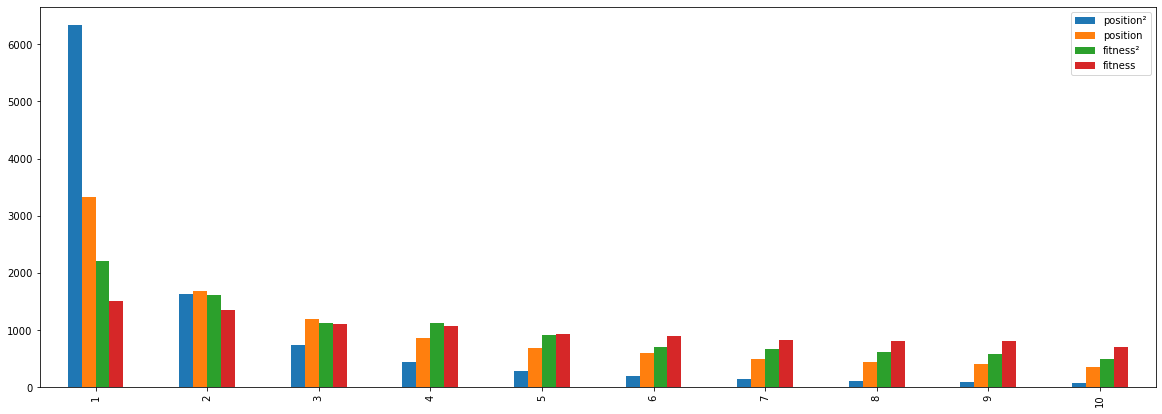

In [42]:
# vergeleich der selection methoden
test_fitness_werte = [[17],[19],[23],[24],[26],[29],[30],[31],[32],[36]]

def selection_test(population_with_fitness, fitness, exponent=1):
    selections= {}
    t = 10000
    while t > 0:
        count = 0
        posibilities = []
        summe = 0
        pos = 1

        for i in population_with_fitness:

            if fitness:
                p = (1/i[0])**exponent
            else:
                p = (1/pos)**exponent

            summe += p
            pos += 1
            posibilities.append([summe, i])
        rnd = random.uniform(0, summe)

        for i in posibilities:
            count += 1
            if rnd < i[0]:
                selection = count
                break

        if selection not in selections:
            selections[selection] = 0
        selections[selection] = selections[selection] + 1
        
        t -= 1

    return selections

fitness_related = selection_test(test_fitness_werte, fitness=True)
fitness_related_squared = selection_test(test_fitness_werte, fitness=True, exponent=2)
position_related = selection_test(test_fitness_werte, fitness=False)
position_related_squared = selection_test(test_fitness_werte, fitness=False, exponent=2)

fitness_related = dict(sorted(fitness_related.items()))
df_fitness = pd.DataFrame([fitness_related])
df_fitness = pd.DataFrame.transpose(df_fitness)

fitness_related_squared = dict(sorted(fitness_related_squared.items()))
df_fitness_squared = pd.DataFrame([fitness_related_squared])
df_fitness_squared = pd.DataFrame.transpose(df_fitness_squared)

position_related = dict(sorted(position_related.items()))
df_position = pd.DataFrame([position_related])
df_position = pd.DataFrame.transpose(df_position)

position_related_squared = dict(sorted(position_related_squared.items()))
df_position_squared = pd.DataFrame([position_related_squared])
df_position_squared = pd.DataFrame.transpose(df_position_squared)

df_all = pd.concat([df_position_squared, df_position, df_fitness_squared, df_fitness], axis=1)
df_all.columns = ['position²', 'position', 'fitness²', 'fitness']
df_all.plot(kind="bar", figsize=[20,7])
plt.show()

##### Beschreibung der Selektionsfunktion mit unterschiedlichen Varianten
Die Selektion der Eltern passiert zufällig, allerdings ist es wahrscheinlicher, dass ein Individuum ausgewählt wird, je besser die Fitness ist. Das ist das Vorgehen, das in [Lösung des TSP Problems](https://www.hdm-stuttgart.de/~maucher/Python/FunktionenAlgorithmen/html/genAlgTSP.html) beschrieben ist. Allerdings müssen wir von den Fitnesswerten den Kehrwert nehemen, da in unserem Fall der Fitnesswert besser ist, je kleiner er ist.  
Da die Fitnesswerte sehr nah beieinander liegen, können dadurch mit auch relativ schlechte Individuen gewählt werden.
Wenn es gewollt ist, dass bessere Individuen häufiger gewählt werden, kann der Fitnesswert quadriert werden. Dadurch bekommen bessere Individuen ein größeres Gewicht.  

Anstatt die Eltern mithilfe der Fitness zu wählen, kann auch der Rang, genutzt werden, wenn nach der Fitness geordnet wird. Dadurch werden die Individuen mit besserer Fitness bevorzugt. Möchte man diese Position stärker gewichten kann die Position quadriert werden.

Im oberen Balkendiagramm wird die Verteilung der Auswahl von 10 Individuen dargestellt in den Unterscheidlichen Selektionvarianten dargestellt. Die gleichmäßigste Verteilung ist die Berechnung mithilfe der Fitness, die ungleichmäßigste Verteilung ist die Berechnung mithilfe der quadrierten Position.

##### Beschreibung der Kreuzungsfunktion
Bei der Kreuzungfunktion haben wir uns für eine komplett zufällige Ausahl der einzelnen Merkmale entschieden.
1. Ein Kind _k_ wird als leeres Array angelegt
2. Wir wählen ein Zufälliges Chromosom _c_ aus
3. Aus _c_ wählen wir ein zufälliges Merkmal _m_ aus
4. ist _m_ noch nicht in _k_ wird es hinzugefügt

Diese Schritte werden wiederholt bis das Kind genauso viele Elemente hat wie die Chromosomen.  
Das ganze wird zweimal ausgeführt, um zwei Kinder zu bekommen. Dabei kann es passieren, dass beide Kinder die gleichen Merkmale haben. Das könnte man verhindern, indem man überprüft ob beide Kinder die selben Merkmale enthalten, allerdings kann es passieren das nach einigen Iterationen beide Eltern bereits die selben Merkmale haben. So kann es das einzige ergebnis sein, dass beide Kinder identisch sind.  

Wir haben uns für die komplett zufällige Auswahl entschieden, da die Kreuzungfunktion im Beispiel mit Vektoren arbeitet, die sich nicht über unterschiedliche Elemente unterscheiden, sonderun durch die Reihenfolge der Elemente im Vektor.

##### Beschreibung der Mutationsfunktion
Aus dem selben Grund wie bei der Kreuzung kann auch die Muation nicht aus dem Beispiel übernommen werden. Stattdessen tauschen wir im Kind ein zufälliges Merkmal mit einem noch nicht vorhanden aus. Die Mutation findet in einem von zehn Fällen statt.

#### Music Feature Selection

In [70]:
#3.
def gentest(pop, feat, its, sim):
    #starttime = timeit.default_timer()#
    genetic_result = genetic_algorithm(
        df_features_train, 
        df_features_test, 
        population_size=pop, 
        feature_size=feat, 
        iterations=its, 
        sim=sim
    )
    #print("Time:", timeit.default_timer() - starttime, pop, feat, its)#
    print("Meanrank:", genetic_result[1][-1])
    string = "subFeaturesTrain1.csv"
    df_features_train[genetic_result[0][0][1]].to_csv(string)
    plt.title('Meanrank pro Iteration')
    plt.plot(genetic_result[1])
    plt.show()
    return genetic_result

result = gentest(8, 20, 1500, distance.euclidean)
print("Gelernte Merkmale:")
display(result[0][0][1])

Meanrank: 8.287671232876713


Gelernte Merkmale:


['duration10mean',
 'duration20mean',
 'loudness33skew',
 'timbre10dstd',
 'loudness10mean',
 'pitches20dskew',
 'pitches100mean',
 'pitches20dstd',
 'pitches10std',
 'pitches20mean',
 'timbre100mean',
 'timbre10kurt',
 'timbre100dstd',
 'loudness10dskew',
 'pitches33mean',
 'loudness20mean',
 'duration33mean',
 'pitches10mean',
 'loudness20dkurt',
 'loudness33mean']

Meanrank: 9.205479452054794


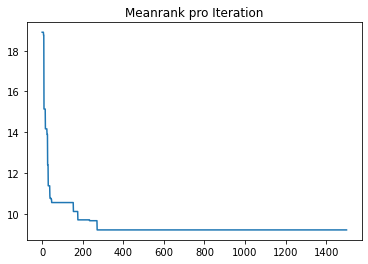

In [67]:
result = gentest(8, 10, 1500, distance.euclidean)

Der Meanrank verschlechtert sich bei nur 10 Merkmalen um ungefähr einem Rang.

## Clustering und automatische Playlistgenerierung
Implementieren Sie ein hierarchisches Clustering aller Subsequenzen in *subFeaturesTrain1.csv*. Diese *.csv*-Datei enthält nur die im vorigen Schritt ermittelten wichtigsten Merkmale. Das hierarchische Clustering ist in einem Dendrogram der Art wie in der unten gegebenen Abbildung zu visualisieren.

Die gefundenen Cluster sind mit den zugehörigen Musiktiteln in der Konsole auszugeben. 

**Aufgaben:**

1. Optimieren Sie die Parameter

    1. metric (Ähnlichkeitsmaß)
    2. linkage method
    3. Clusteranzahl
    
2. Für welche Parameterkonstellation erlangen Sie das für Sie subjektiv betrachtet günstigste Ergebnis?
3. Überlegen Sie sich Ansätze um diese Art der Musikgruppierung zu verbessern?

<img src="https://maucher.home.hdm-stuttgart.de/Pics/playlistCluster.png" style="width:1000px" align="center">




In [43]:
subfeat = pd.read_csv("subFeaturesTrain1.csv", index_col=0)

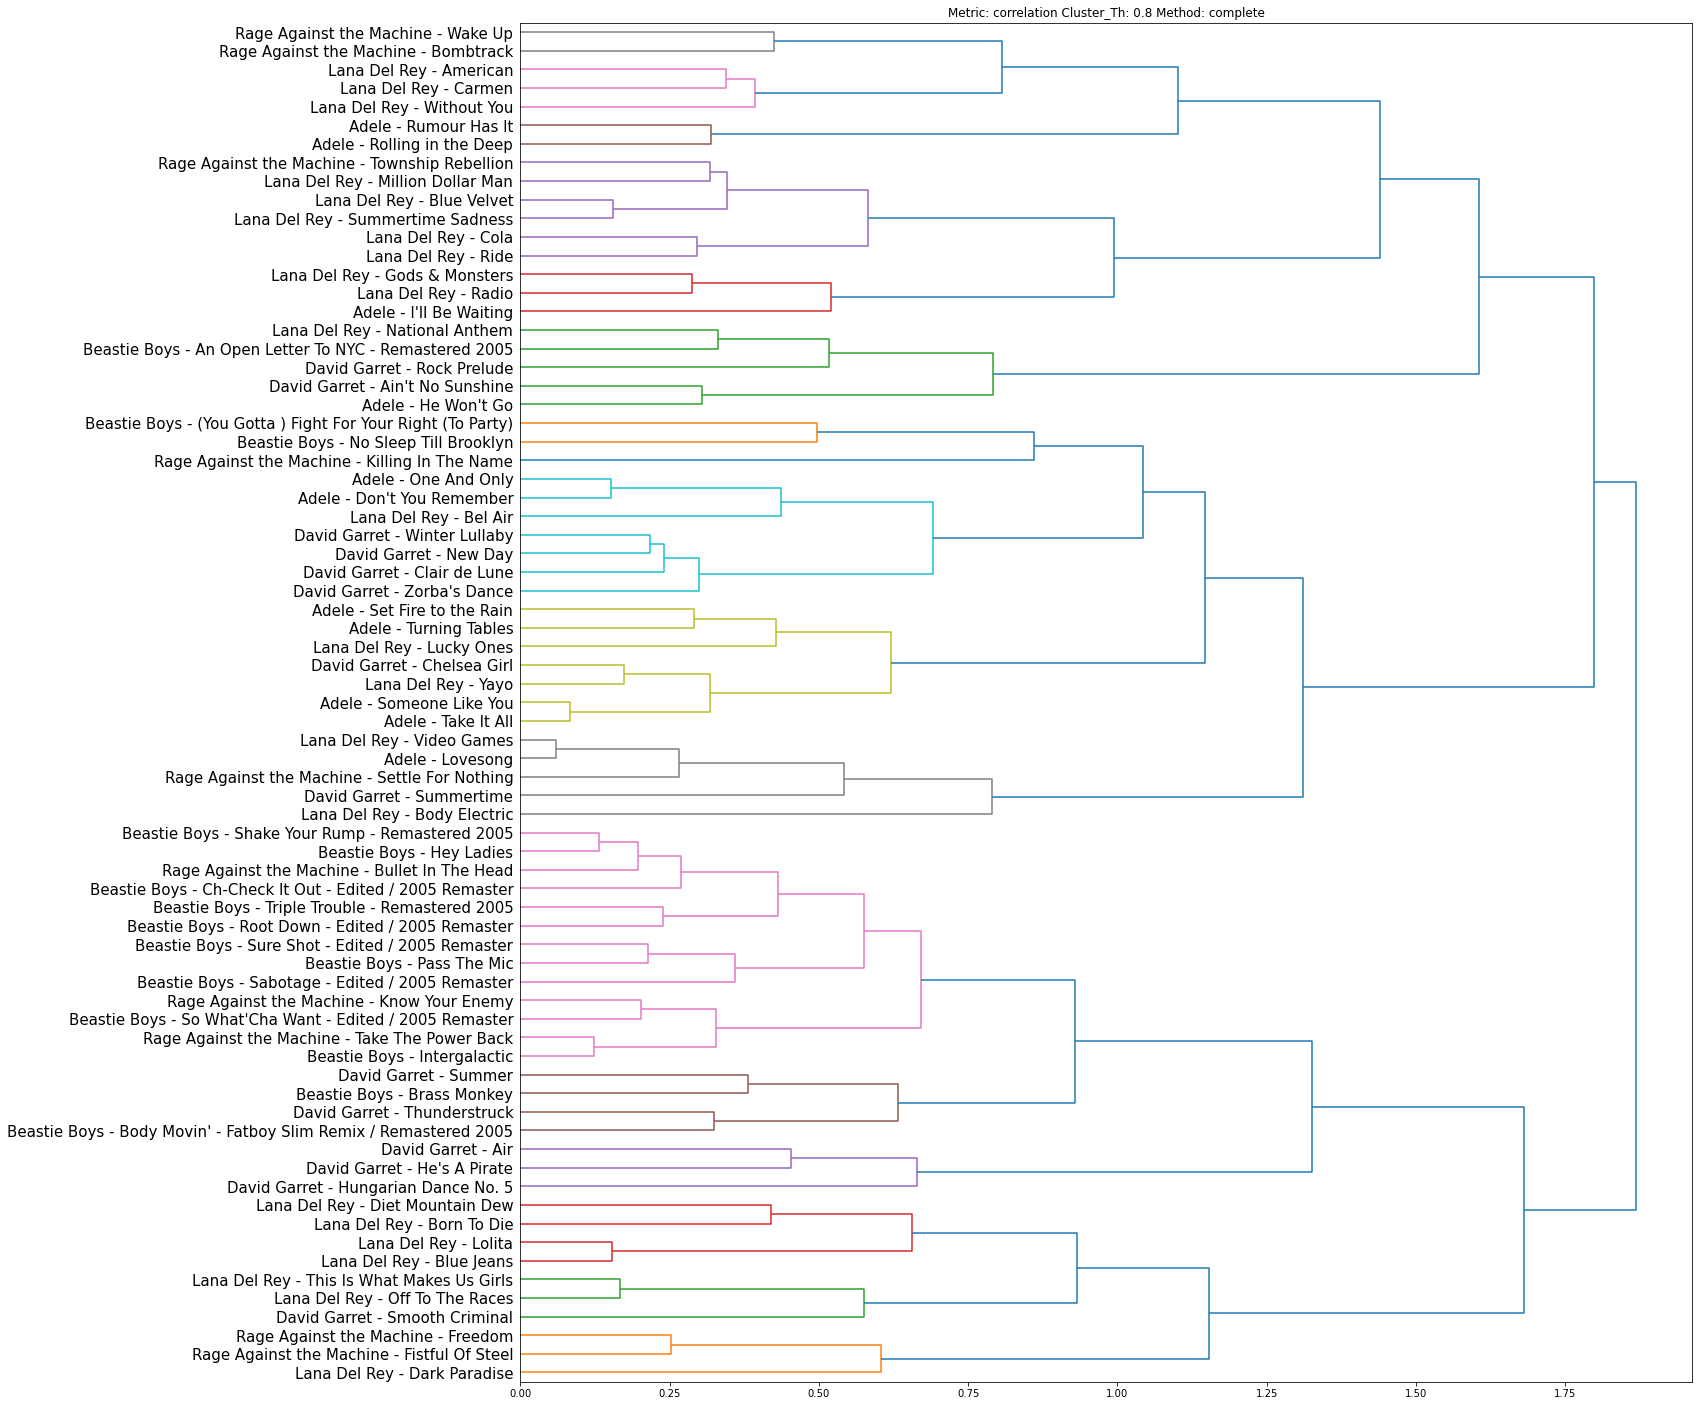

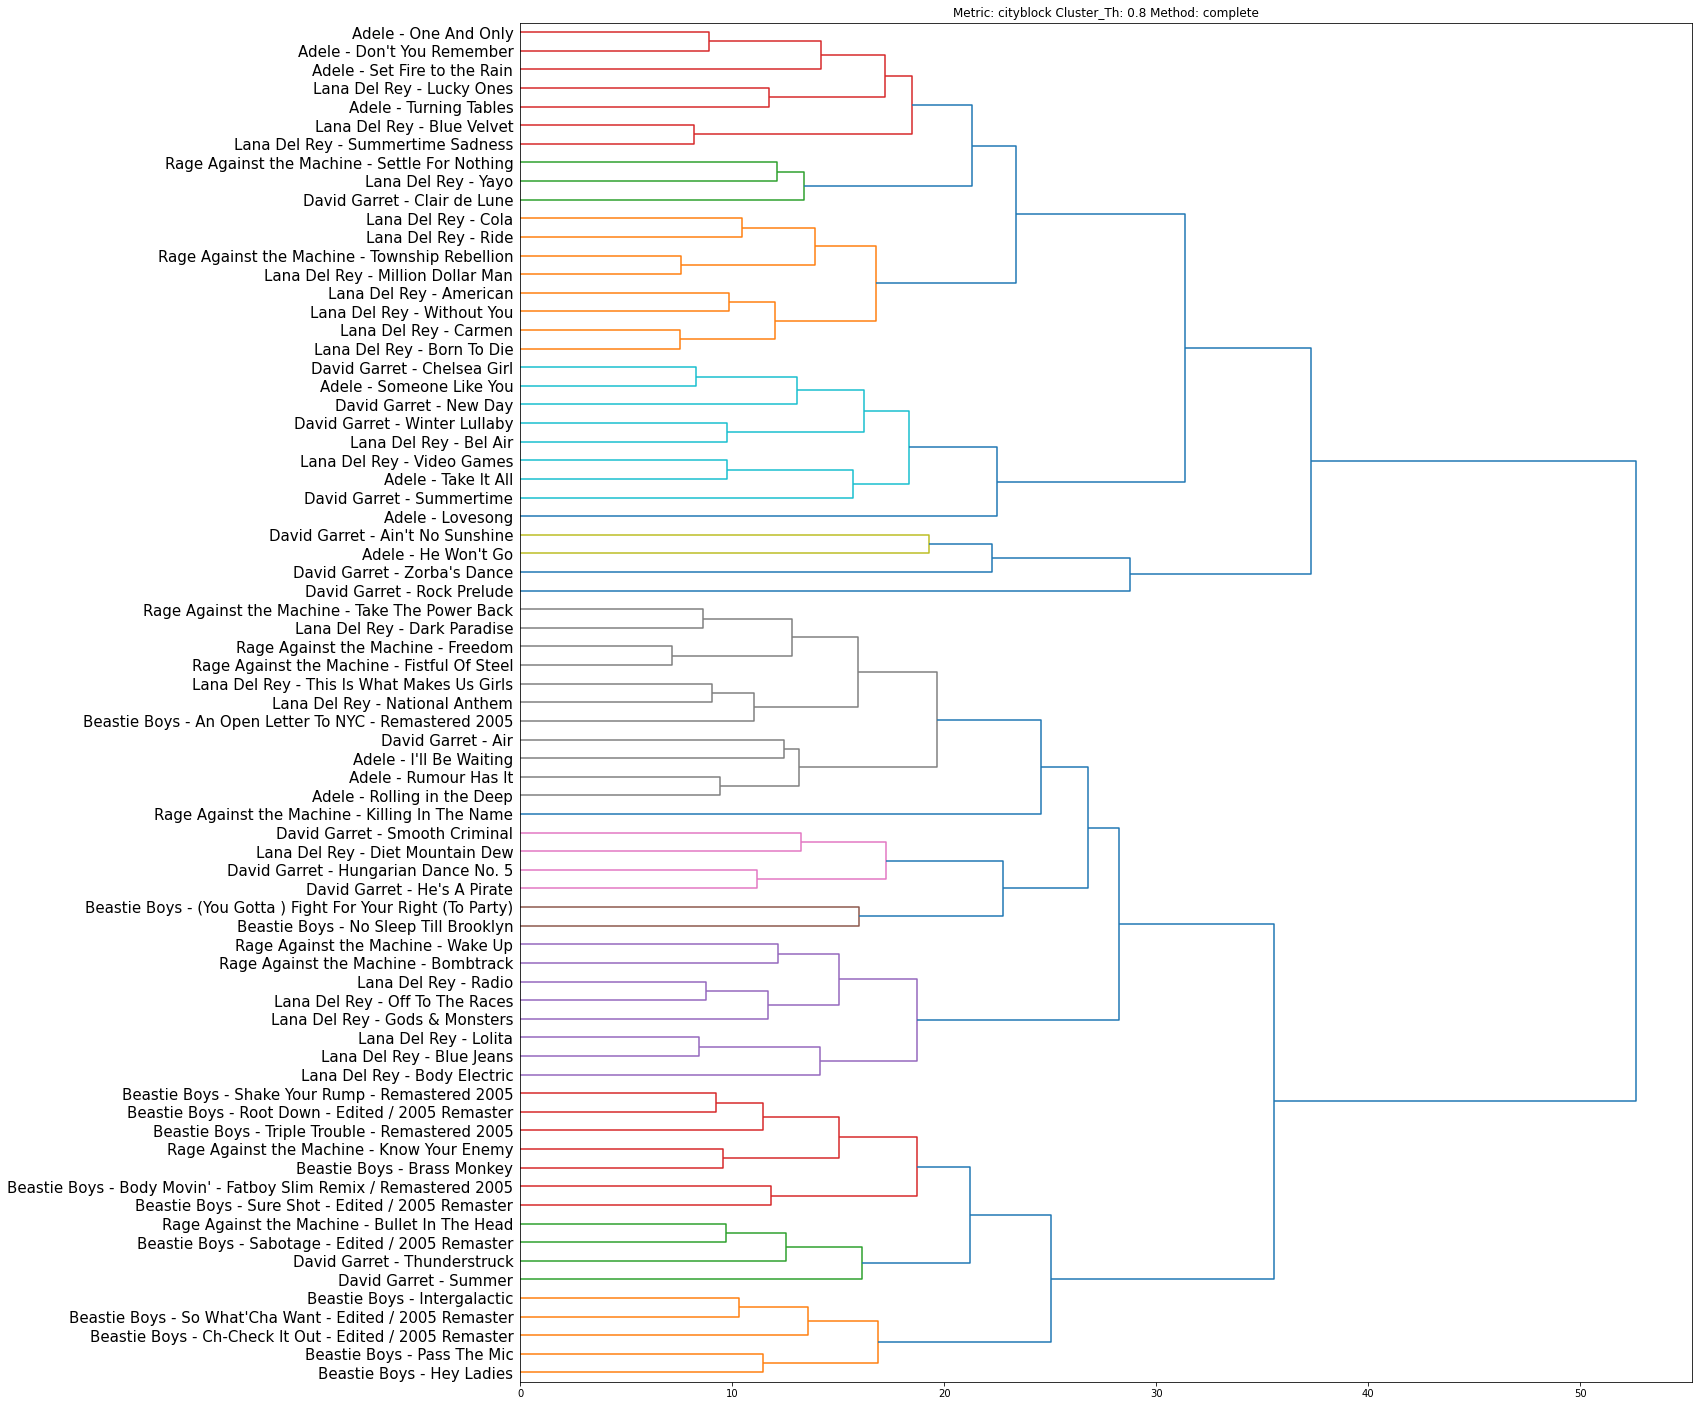

In [44]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(subfeat, 'complete', metric="euclidean")
plt.figure(figsize=(21, 25))
plt.title("Metric: euclidean Cluster_Th: 7 Method: complete")
dendrogram(linked, labels=subfeat.index, orientation="right", leaf_font_size=15, color_threshold=5)
plt.show()

linked = linkage(subfeat, 'ward', metric="euclidean")
plt.figure(figsize=(21, 25))
plt.title("Metric: euclidean Cluster_Th: 7 Method: ward")
dendrogram(linked, labels=subfeat.index, orientation="right", leaf_font_size=15, color_threshold=7)
plt.show()

linked = linkage(subfeat, 'complete', metric="correlation")
plt.figure(figsize=(21, 25))
plt.title("Metric: correlation Cluster_Th: 0.8 Method: complete")
dendrogram(linked, labels=subfeat.index, orientation="right", leaf_font_size=15, color_threshold=0.8)
plt.show()

linked = linkage(subfeat, 'complete', metric="cityblock")
plt.figure(figsize=(21, 25))
plt.title("Metric: cityblock Cluster_Th: 0.8 Method: complete")
dendrogram(linked, labels=subfeat.index, orientation="right", leaf_font_size=15, color_threshold=20)
plt.show()



Die Clusteranzahl kann bei uns nicht angepasst werden, da bei einem hierarchischen Clustering diese nicht benötigt wird, jedoch können wir für die Diagramme ein 'Color threshold' angeben, wodurch unsere 'Clusteranzahl' visuell dargestellt werden. Mit dem Color Threshold wird angegeben welche Lieder, die gemerged unter dem Threshold liegen, zu einem Cluster zusammengefasst werden.

Subjektiv betrachtet ist das erste Dendrogram, mit euklidischer Distanz und der Metrik 'complete' und einer Clusteranzahl von 16, das Beste.

### Verbesserung der Musikgruppierung
Aktuell werden nur die Eigenschaften wie Lautstärke, Tonhöhe, Länge und Tonfarbe eines Segements als Features benutzt. Deswegen können Lieder im gleichen Cluster landen, die aber von Grund auf sehr verschieden sind. Zum Beispiel kann ein Rock Lied mit einem Klassischen Lied in einem Cluster landen, wenn sich diese in der Lautstärke, Tonhöhe und Länge des Segmentes sehr ähnlich sind. Auch die Tonfarbe kann bei diesem Beispiel sehr ähnlich werden, da in Rock und Klassischer Musik Saiteninstrumente und Schlaginstrumente befinden.

Was noch hinzukommt, ist dass die Teilsequenzen, mit denen die Distanzen berechnet werden, nur ein kleiner Ausschnitt aus dem ganzen Lied sind. Dadurch kann es vorkommen, dass nur die Intros von Liedern verglichen werden. Dabei kann vorkommen, dass ein Rock Lied mit einem sanften Intro mit einem genrell ruhigen Lied in den gleichen Cluster zugewiesen werden.

# Weitere Ideen
* Spotify bietet auch schon einen Endpoint für berechnete [Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) an, die z.B. die Acousticness, Tanzbarkeit, Tempo oder angeben ob ein Gesang vorhanden ist.
* Diese Features können leicht mit anderen Cluster-Methoden gruppiert werden. Probieren Sie verschiedene [Clustering-Methoden](https://scikit-learn.org/stable/modules/clustering.html) aus, auf die bereits berechneten Features des Endpoints. Wie unterscheiden sich die generierten Playlists untereinander?
* Die bereitgestellte Methode speichert die Audio Features in einem Pandas DataFrame.

In [45]:
albums = [('Adele', '21'), 
          ('Beastie Boys', 'Solid Gold Hits'), 
          ('Lana Del Rey', 'Born To Die'),
          ('David Garret', 'Encore'),
          ('Rage Against the Machine', 'Rage Against the Machine')]


song_features = {}
for artist, album in albums:
    results = sp.search(q=f'album:{album} artist:{artist}', type='album', limit=1)
    if results['albums']['total'] == 0:
        print(f'No album found for: {artist} - {album}!')
        continue
        
    print(f'collect features for {artist} - {album}')
    for el in results['albums']['items']:
        album_id = el['id']
        tracks = sp.album_tracks(album_id)
        for track in tracks['items']:
            if 'Demo' in track["name"] or 'Live' in track["name"]:
                continue
            song_features[artist + " - " + track['name']] = sp.audio_features(track['id'])[0]
            
spotify_features = pd.DataFrame(list(song_features.values()), index=song_features.keys())
spotify_features.head(20)

collect features for Adele - 21
collect features for Beastie Boys - Solid Gold Hits
collect features for Lana Del Rey - Born To Die
collect features for David Garret - Encore
collect features for Rage Against the Machine - Rage Against the Machine


danceability  energy  key  \
Adele - Rolling in the Deep                                0.730   0.769    8   
Adele - Rumour Has It                                      0.612   0.749    0   
Adele - Turning Tables                                     0.353   0.446    0   
Adele - Don't You Remember                                 0.644   0.400    3   
Adele - Set Fire to the Rain                               0.603   0.670    2   
Adele - He Won't Go                                        0.706   0.570    0   
Adele - Take It All                                        0.415   0.266    0   
Adele - I'll Be Waiting                                    0.547   0.848    2   
Adele - One And Only                                       0.528   0.468    5   
Adele - Lovesong                                           0.689   0.369    0   
Adele - Someone Like You                                   0.556   0.319    9   
Beastie Boys - So What'Cha Want - Edited / 2005...         0.693   0.955    5   
Beastie Boys - Brass Monkey                                0.945   0.504    6   
Beastie Boys - Ch-Check It Out - Edited / 2005 ...         0.795   0.910    1   
Beastie Boys - No Sleep Till Brooklyn                      0.771   0.473    8   
Beastie Boys - Hey Ladies                                  0.948   0.840    1   
Beastie Boys - Pass The Mic                                0.625   0.896    7   
Beastie Boys - An Open Letter To NYC - Remaster...         0.705   0.781    1   
Beastie Boys - Root Down - Edited / 2005 Remaster          0.832   0.962    5   
Beastie Boys - Shake Your Rump - Remastered 2005           0.891   0.807   10   

                                                    loudness  mode  \
Adele - Rolling in the Deep                           -5.114     1   
Adele - Rumour Has It                                 -5.014     1   
Adele - Turning Tables                                -6.044     0   
Adele - Don't You Remember                            -5.713     1   
Adele - Set Fire to the Rain                          -3.882     0   
Adele - He Won't Go                                   -7.045     0   
Adele - Take It All                                   -8.440     1   
Adele - I'll Be Waiting                               -2.684     1   
Adele - One And Only                                  -5.306     1   
Adele - Lovesong                                      -9.407     0   
Adele - Someone Like You                              -8.251     1   
Beastie Boys - So What'Cha Want - Edited / 2005...    -5.656     0   
Beastie Boys - Brass Monkey                           -8.560     0   
Beastie Boys - Ch-Check It Out - Edited / 2005 ...    -6.268     1   
Beastie Boys - No Sleep Till Brooklyn                 -9.734     1   
Beastie Boys - Hey Ladies                             -6.234     1   
Beastie Boys - Pass The Mic                           -5.527     1   
Beastie Boys - An Open Letter To NYC - Remaster...    -7.428     0   
Beastie Boys - Root Down - Edited / 2005 Remaster     -5.352     1   
Beastie Boys - Shake Your Rump - Remastered 2005      -6.329     0   

                                                    speechiness  acousticness  \
Adele - Rolling in the Deep                              0.0298       0.13800   
Adele - Rumour Has It                                    0.0446       0.61500   
Adele - Turning Tables                                   0.0285       0.95000   
Adele - Don't You Remember                               0.0304       0.21400   
Adele - Set Fire to the Rain                             0.0249       0.00408   
Adele - He Won't Go                                      0.0860       0.02250   
Adele - Take It All                                      0.0308       0.95700   
Adele - I'll Be Waiting                                  0.0367       0.04900   
Adele - One And Only                                     0.0287       0.29500   
Adele - Lovesong                                         0.0278      

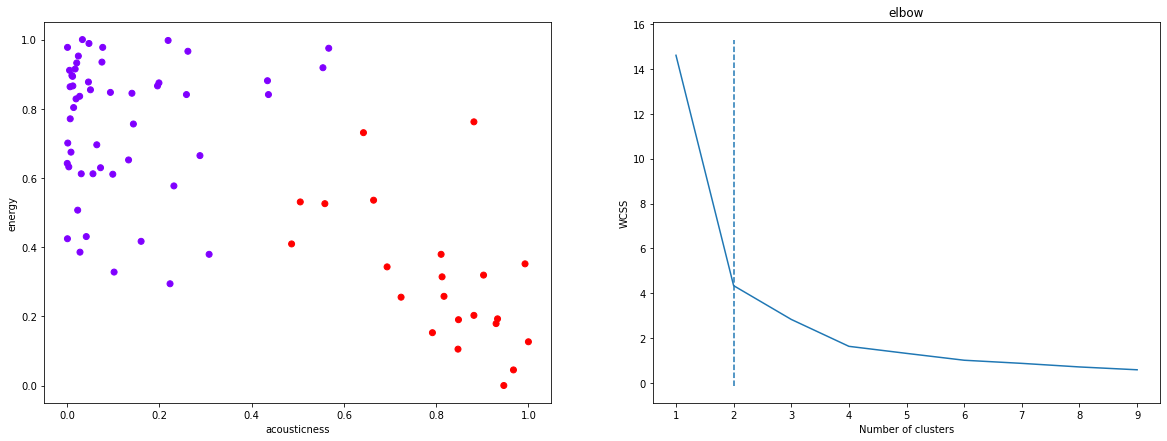

{'Playlist 0': array(['Adele - Rolling in the Deep', "Adele - Don't You Remember",
        'Adele - Set Fire to the Rain', "Adele - He Won't Go",
        "Adele - I'll Be Waiting", 'Adele - One And Only',
        "Beastie Boys - So What'Cha Want - Edited / 2005 Remaster",
        'Beastie Boys - Brass Monkey',
        'Beastie Boys - Ch-Check It Out - Edited / 2005 Remaster',
        'Beastie Boys - No Sleep Till Brooklyn',
        'Beastie Boys - Hey Ladies', 'Beastie Boys - Pass The Mic',
        'Beastie Boys - An Open Letter To NYC - Remastered 2005',
        'Beastie Boys - Root Down - Edited / 2005 Remaster',
        'Beastie Boys - Shake Your Rump - Remastered 2005'], dtype=object),
 'Playlist 1': array(['Adele - Rumour Has It', 'Adele - Turning Tables',
        'Adele - Take It All', 'Adele - Lovesong',
        'Adele - Someone Like You', 'Lana Del Rey - Video Games',
        'Lana Del Rey - Million Dollar Man', 'Lana Del Rey - Without You',
        'Lana Del Rey - Lucky Ones',

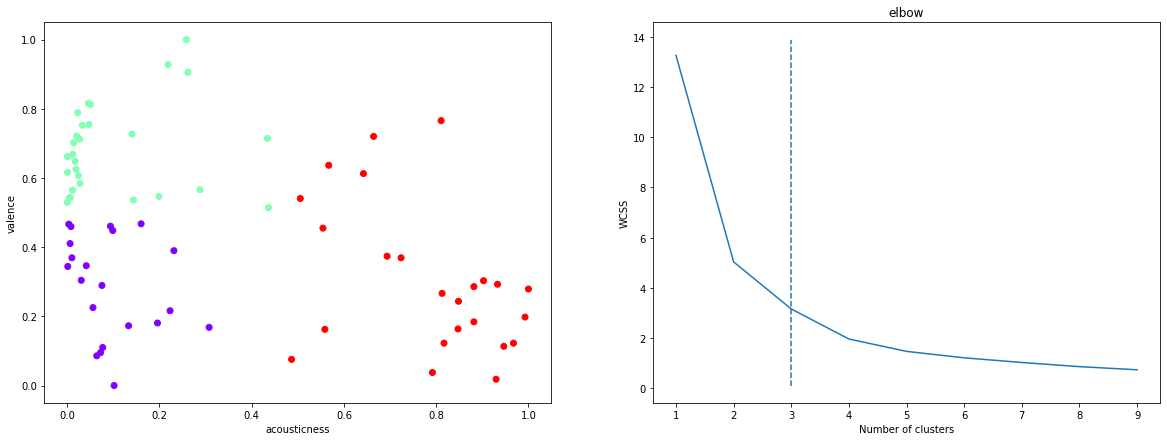

{'Playlist 0': array(["Adele - Don't You Remember", 'Adele - Set Fire to the Rain',
        'Adele - One And Only', 'Beastie Boys - Intergalactic',
        'Lana Del Rey - Born To Die', 'Lana Del Rey - Off To The Races',
        'Lana Del Rey - Dark Paradise', 'Lana Del Rey - Radio',
        'Lana Del Rey - Carmen', 'Lana Del Rey - Summertime Sadness',
        'Lana Del Rey - This Is What Makes Us Girls',
        'Lana Del Rey - Lolita', 'Lana Del Rey - Ride',
        'Lana Del Rey - Cola', 'Lana Del Rey - Gods & Monsters'],
       dtype=object),
 'Playlist 1': array(['Adele - Rolling in the Deep', "Adele - He Won't Go",
        "Adele - I'll Be Waiting",
        "Beastie Boys - So What'Cha Want - Edited / 2005 Remaster",
        'Beastie Boys - Brass Monkey',
        'Beastie Boys - Ch-Check It Out - Edited / 2005 Remaster',
        'Beastie Boys - No Sleep Till Brooklyn',
        'Beastie Boys - Hey Ladies', 'Beastie Boys - Pass The Mic',
        'Beastie Boys - An Open Letter To NYC

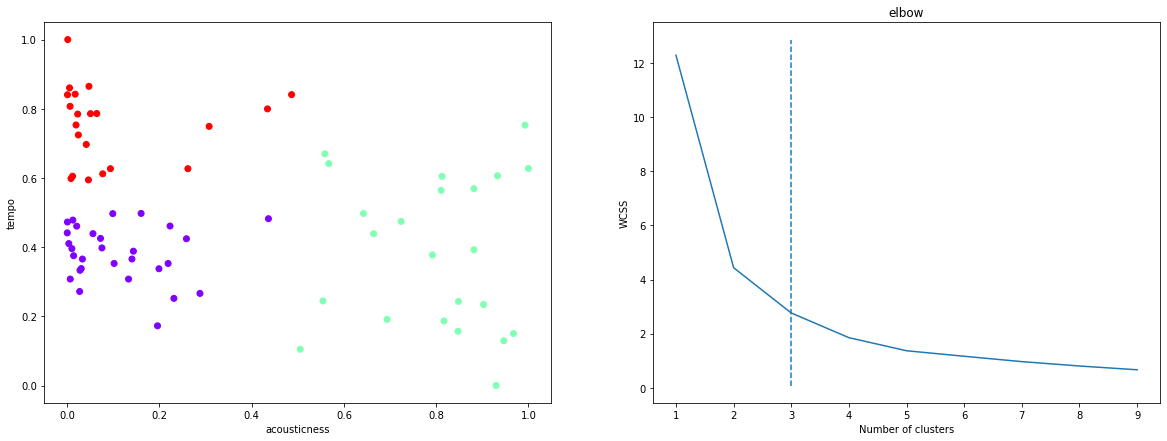

{'Playlist 0': array(['Adele - Rolling in the Deep', "Adele - Don't You Remember",
        'Adele - Set Fire to the Rain', 'Beastie Boys - Brass Monkey',
        'Beastie Boys - Ch-Check It Out - Edited / 2005 Remaster',
        'Beastie Boys - No Sleep Till Brooklyn',
        'Beastie Boys - Hey Ladies',
        'Beastie Boys - An Open Letter To NYC - Remastered 2005',
        'Beastie Boys - Root Down - Edited / 2005 Remaster',
        'Beastie Boys - Shake Your Rump - Remastered 2005',
        'Beastie Boys - Intergalactic',
        'Beastie Boys - Sure Shot - Edited / 2005 Remaster',
        "Beastie Boys - Body Movin' - Fatboy Slim Remix / Remastered 2005",
        'Beastie Boys - Triple Trouble - Remastered 2005',
        'Lana Del Rey - Born To Die'], dtype=object),
 'Playlist 1': array(['Adele - Rumour Has It', 'Adele - Turning Tables',
        'Adele - Take It All', 'Adele - Lovesong',
        'Adele - Someone Like You', 'Lana Del Rey - Video Games',
        'Lana Del Rey - Na

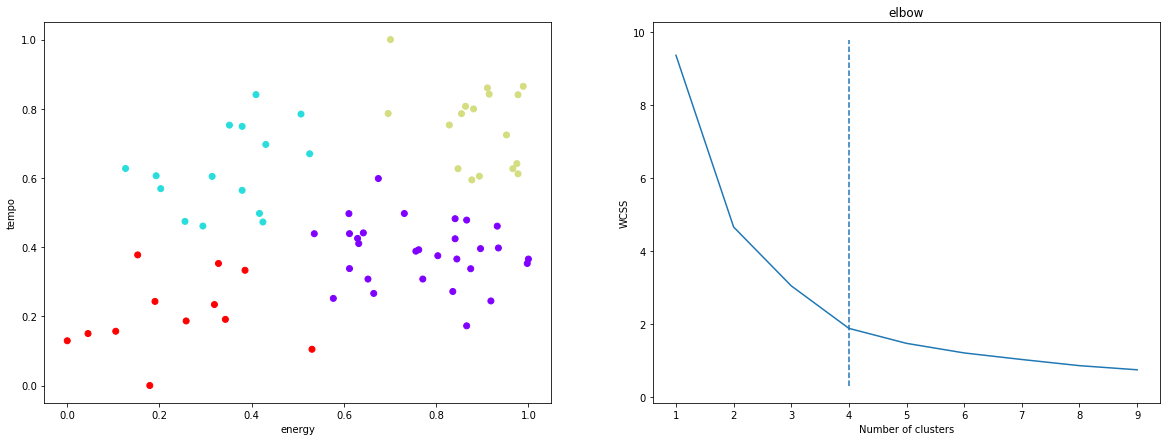

{'Playlist 0': array(['Adele - Rolling in the Deep', 'Adele - Rumour Has It',
        'Adele - Set Fire to the Rain',
        'Beastie Boys - Ch-Check It Out - Edited / 2005 Remaster',
        'Beastie Boys - Hey Ladies',
        'Beastie Boys - An Open Letter To NYC - Remastered 2005',
        'Beastie Boys - Root Down - Edited / 2005 Remaster',
        'Beastie Boys - Shake Your Rump - Remastered 2005',
        'Beastie Boys - Intergalactic',
        'Beastie Boys - Sure Shot - Edited / 2005 Remaster',
        "Beastie Boys - Body Movin' - Fatboy Slim Remix / Remastered 2005",
        'Beastie Boys - Triple Trouble - Remastered 2005',
        'Lana Del Rey - Born To Die', 'Lana Del Rey - Blue Jeans',
        'Lana Del Rey - Diet Mountain Dew'], dtype=object),
 'Playlist 1': array(['Adele - Turning Tables', "Adele - Don't You Remember",
        "Adele - He Won't Go", 'Adele - Take It All',
        'Adele - One And Only', 'Adele - Lovesong',
        'Adele - Someone Like You', 'Beastie

In [48]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
from kneed import KneeLocator




plot_features = [
    ["acousticness", "energy"],
    ["acousticness", "valence"],
    ["acousticness", "tempo"],
    ["energy", "tempo"]
]


for features in plot_features:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        A = features[0]
        B = features[1]
        # scaling der Werte, da manche Werte von 0-1 gehen aber andere von 0-180, was manche Werte zu stark gewichtet
        spotify_features[[A, B]] = min_max_scaler.fit_transform(spotify_features[[A, B]])
        x = spotify_features[features]
        
        
        ######################### ANFANG #########################
        # Codeteil wurde von diesem Tutorial kopiert https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/#:~:text=Step%2D1%3A%20Select%20the%20value,will%20form%20the%20predefined%20clusters
        wcss=[]
        for i in range(1,10):
            kmeans = KMeans(i)
            kmeans.fit(x)
            wcss_iter = kmeans.inertia_
            wcss.append(wcss_iter)

        number_clusters = range(1,10)
        fig, ax = plt.subplots(1, 2, figsize=(20,7))
        ax[1].plot(number_clusters,wcss)
        ax[1].set_title('elbow')
        ax[1].set_xlabel('Number of clusters')
        ax[1].set_ylabel('WCSS')
        
        kn = KneeLocator(number_clusters, wcss, curve='convex', direction='decreasing')
        ax[1].vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
        ######################### ENDE #########################
        
        kmeans = KMeans(n_clusters=kn.knee)
        y = kmeans.fit_predict(x)

        data_with_clusters = spotify_features.copy()
        data_with_clusters['Clusters'] = y 
        ax[0].scatter(data_with_clusters[A],data_with_clusters[B],c=data_with_clusters['Clusters'],cmap='rainbow')

        ax[0].set_xlabel(A)
        ax[0].set_ylabel(B)
        plt.show()
        
        playlists ={}
        for i in range(0,kn.knee):
            playlists["Playlist " + str(i)] = np.array(data_with_clusters.loc[data_with_clusters['Clusters'] == i].head(15).index)
        display(playlists)

##### Erklärung der Graphen

Mit den neuen Merkmalen haben wir die Möglichkeit die zwei Merkmale auszusuchen, zu Clustern und diese in einem 2D Plot darzustellen. Wir haben folgende Merkmalkombinationen gewählt:
- acousticness und energy
- acousticness und valence
- acousticness und tempo
- energy und tempo

Manche Werte gehen von 0-1 und andere von 0-190. Damit die Merkmale mit größeren Werten nicht stärker gewichtet werden müssen wir diese noch moramlisieren.

Um rauszufinden wie viele Cluster ideal sind kann man eine Elbowfunktion erstellen. Für jeden Punkt in einem Cluster wird die Distanz zum Zentrum seines Clusters quadriert und aufsummiert. Diese Summe wird für unterschiedliche Clusteranzahlen berechnet und geplottet. Von diesem Plot kann man den Elbow finden. Der Elbow ist die ideale Anzahl an Clustern. Um den Elbow zu finden haben wir eine Library importiert, die dies übernimmt (KneeLocator). 

Wenn wir die ideale Anzahl der Cluster wissen können wir mit Kmeans unsere Werte den Clustern zuordnen und farbig plotten.